In [ ]:
 !apt-get -y install openjdk-8-jre-headless
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc = SparkContext.getOrCreate()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jre-headless is already the newest version (8u282-b08-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
appName = "Sentiment Analysis with Vaccine Tweets"
spark = SparkSession.builder.appName(appName).config("spark.some.config.option", "some-value").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#tweets = spark.read.json("/content/ans_twt.json")
tweets = spark.read.json("/content/drive/MyDrive/ans_twt1.json")

In [ ]:
x = spark.read.json("/content/drive/MyDrive/ans_twt1.json")

In [ ]:
print((x.count(), len(x.columns)))

(277066, 38)


In [ ]:
tweets2 = spark.read.json("/content/drive/MyDrive/ans_twt5.json")

In [ ]:
x2 = spark.read.json("/content/drive/MyDrive/ans_twt5.json")

In [ ]:
print((x2.count(), len(x2.columns)))

(239140, 37)


In [ ]:
tweets.show(5)

+------------+-----------+--------------------+------------------+--------------------+-----------------+--------------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+-----+------------------+-----------+--------------------+-------------------+--------------------+-----------------------+-----------+-------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+---------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|limit|place|

In [ ]:
tweets.count()

277066

In [ ]:
tweets2.show(5)

+------------+-----------+--------------------+------------------+--------------------+-----------------+--------------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+-------------+----------------+--------------------+-----------------------+-----------+-------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+---------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sensitive|quo

In [ ]:
tweets2.count()

239140

In [ ]:
df = tweets
drop_column_list = ["_corrupt_record", "contributors","coordinates", "created_at","display_text_range", "entities", "extended_entities","extended_tweet","favorite_count", "favorited","filter_level","geo","id","id_str","in_reply_to_screen_name","in_reply_to_status_id","in_reply_to_status_id_str", "in_reply_to_user_id", "in_reply_to_user_id_str","is_quote_status","lang","limit","place","possibly_sensitive","quote_count","quoted_status","quoted_status_id","quoted_status_id_str","quoted_status_permalink","reply_count","retweet_count","retweeted","retweeted_status","source","timestamp_ms","truncated","user","withheld_in_countries"]
tweets = tweets.select([column for column in df.columns if column not in drop_column_list])  

In [ ]:
tweets.show(5,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                        |
+--------------------------------------------------------------------------------------------------------------------------------------------+
|RT @taoquei1: Ohhh Brasil, o que fizeram com vc? 😞                                                                                         |
|@Medicina_CFM CFM acima de todos... devem ter debatido l kit covid, a nebulização...                                                        |
|1/2. A record 74,927 doses of the various COVID-19 vaccines were administered in Quebec on Thursday . The 15,522 do… https://t.co/Qw2KNX4gIy|
|RT @Arvindharmapuri: COVID-19 పాజిటివ్ గా నిర్ధారణ అయిన శ్రీ పవన్ కళ్యాణ్ గారు త్వరగా కోలుకోవాలని భగవంతుణ్ణి ప్రార్ధిస్తున్నాను.

Praying f…|


In [ ]:
len(drop_column_list)

38

In [ ]:
df2 = tweets
drop_column_list2 = ["_corrupt_record", "contributors","coordinates", "created_at","display_text_range", "entities", "extended_entities","extended_tweet","favorite_count", "favorited","filter_level","geo","id","id_str","in_reply_to_screen_name","in_reply_to_status_id","in_reply_to_status_id_str", "in_reply_to_user_id", "in_reply_to_user_id_str","is_quote_status","lang","place","possibly_sensitive","quote_count","quoted_status","quoted_status_id","quoted_status_id_str","quoted_status_permalink","reply_count","retweet_count","retweeted","retweeted_status","source","timestamp_ms","truncated","user","withheld_in_countries"]
tweets2 = tweets2.select([column for column in df2.columns if column not in drop_column_list2])  

In [ ]:
tweets2.show(5,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                        |
+--------------------------------------------------------------------------------------------------------------------------------------------+
|RT @jason_meister: Joe Biden is double masked while eating lunch despite being vaccinated 97 days ago. The optics do immeasurable damage to…|
|CVS appointments available in EAST FALMOUTH, FALL RIVER, NEW BEDFORD, WALTHAM, WESTPORT. Check eligibility and sign… https://t.co/rjU3RZZRsk|
|RT @SaveGomata: @Rakesh1752 @smitaprakash @Vishnu_Jain1 @GauPrem @madhukishwar @noconversion @ravoria @GauSevaAgniveer @GSamskriti @shopfor…|
|RT @iAsura_: Dear @narendramodi please go all out and find out the source of all anti vaccine propaganda circulating on WhatsApp and other… |

In [ ]:
len(drop_column_list2)

37

**Data Preprocessing**

In [ ]:
tweets.show()

+--------------------+
|                text|
+--------------------+
|RT @taoquei1: Ohh...|
|@Medicina_CFM CFM...|
|1/2. A record 74,...|
|RT @Arvindharmapu...|
|RT @Limbaughnomic...|
|RT @BoyerMichel: ...|
|RT @SigaGazetaBR:...|
|RT @RoflGandhi_: ...|
|Diane Francis: Li...|
|RT @CNBC: Could w...|
|@lamElizaBee @Rep...|
|Las enfermedades ...|
|                null|
|RT @RudaMorcillo:...|
|RT @RealRichardBa...|
|RT @DrVW30: Watch...|
|#COVID19 
#CovidV...|
|RT @GazeteMusteha...|
|RT @Reuters: U.S....|
|Man pleads no con...|
+--------------------+
only showing top 20 rows



In [ ]:
tweets2.show()

+--------------------+
|                text|
+--------------------+
|RT @jason_meister...|
|CVS appointments ...|
|RT @SaveGomata: @...|
|RT @iAsura_: Dear...|
|RT @okiedokiloki:...|
|RT @CREWcrew: AT&...|
|RT @junifactcheck...|
|RT @xi_guzzbelll:...|
|RT @ghitis: Una c...|
|America has a mor...|
|@el_patron_etc Il...|
|Same media houses...|
|@umashankarsingh ...|
|RT @MarcMacDhugai...|
|Walk-up vaccine a...|
|RT @JoeSilverman7...|
|RT @EmmaJoNYC: Ju...|
|RT @TimFullerton:...|
|RT @translatingTX...|
|RT @junifactcheck...|
+--------------------+
only showing top 20 rows



In [ ]:
#remove rows with text = null
tweets = tweets.na.drop(subset=["text"])

In [ ]:
#remove rows with text = null
tweets2 = tweets2.na.drop(subset=["text"])

In [ ]:
tweets.show(5,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                        |
+--------------------------------------------------------------------------------------------------------------------------------------------+
|RT @taoquei1: Ohhh Brasil, o que fizeram com vc? 😞                                                                                         |
|@Medicina_CFM CFM acima de todos... devem ter debatido l kit covid, a nebulização...                                                        |
|1/2. A record 74,927 doses of the various COVID-19 vaccines were administered in Quebec on Thursday . The 15,522 do… https://t.co/Qw2KNX4gIy|
|RT @Arvindharmapuri: COVID-19 పాజిటివ్ గా నిర్ధారణ అయిన శ్రీ పవన్ కళ్యాణ్ గారు త్వరగా కోలుకోవాలని భగవంతుణ్ణి ప్రార్ధిస్తున్నాను.

Praying f…|


In [ ]:
tweets2.show(5,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                        |
+--------------------------------------------------------------------------------------------------------------------------------------------+
|RT @jason_meister: Joe Biden is double masked while eating lunch despite being vaccinated 97 days ago. The optics do immeasurable damage to…|
|CVS appointments available in EAST FALMOUTH, FALL RIVER, NEW BEDFORD, WALTHAM, WESTPORT. Check eligibility and sign… https://t.co/rjU3RZZRsk|
|RT @SaveGomata: @Rakesh1752 @smitaprakash @Vishnu_Jain1 @GauPrem @madhukishwar @noconversion @ravoria @GauSevaAgniveer @GSamskriti @shopfor…|
|RT @iAsura_: Dear @narendramodi please go all out and find out the source of all anti vaccine propaganda circulating on WhatsApp and other… |

**Remove Non-ASCII characters**

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
import string
import re

# remove non ASCII characters
def strip_non_ascii(data_str):
    ''' Returns the string without non ASCII characters'''
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)
# setup pyspark udf function
strip_non_ascii_udf = udf(strip_non_ascii, StringType())

In [ ]:
tweets = tweets.withColumn('text_non_ascii',strip_non_ascii_udf(tweets['text']))
tweets.show(5)

+--------------------+--------------------+
|                text|      text_non_ascii|
+--------------------+--------------------+
|RT @taoquei1: Ohh...|RT @taoquei1: Ohh...|
|@Medicina_CFM CFM...|@Medicina_CFM CFM...|
|1/2. A record 74,...|1/2. A record 74,...|
|RT @Arvindharmapu...|RT @Arvindharmapu...|
|RT @Limbaughnomic...|RT @Limbaughnomic...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
tweets2 = tweets2.withColumn('text_non_ascii',strip_non_ascii_udf(tweets2['text']))
tweets2.show(5)

+--------------------+--------------------+
|                text|      text_non_ascii|
+--------------------+--------------------+
|RT @jason_meister...|RT @jason_meister...|
|CVS appointments ...|CVS appointments ...|
|RT @SaveGomata: @...|RT @SaveGomata: @...|
|RT @iAsura_: Dear...|RT @iAsura_: Dear...|
|RT @okiedokiloki:...|RT @okiedokiloki:...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
def remove_features(data_str):
    # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
    # remove unwanted space, *.split() will automatically split on
    # whitespace and discard duplicates, the " ".join() joins the
    # resulting list into one string.
    return " ".join(cleaned_str.split())
# setup pyspark udf function
remove_features_udf = udf(remove_features, StringType())

In [ ]:
tweets = tweets.withColumn('removed',remove_features_udf(tweets['text_non_ascii']))

In [ ]:
tweets2 = tweets2.withColumn('removed',remove_features_udf(tweets2['text_non_ascii']))

In [ ]:
from pyspark.sql.types import FloatType

from textblob import TextBlob

def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

sentiment_analysis_udf = udf(sentiment_analysis , FloatType())

In [ ]:
#Removed: 0=>neutral, >0 positive, <0 negative
tweets  = tweets.withColumn("sentiment_score", sentiment_analysis_udf(tweets['removed']))

In [ ]:
tweets2  = tweets2.withColumn("sentiment_score", sentiment_analysis_udf(tweets2['removed']))

In [ ]:
def condition(r):
    if (r >=0.1):
        label = "positive"
    elif(r <= -0.1):
        label = "negative"
    else:
        label = "neutral"
    return label

sentiment_udf = udf(lambda x: condition(x), StringType())

In [ ]:
tweets = tweets.withColumn("condition", sentiment_udf(tweets['sentiment_score']))

In [ ]:
tweets2 = tweets2.withColumn("condition", sentiment_udf(tweets2['sentiment_score']))

In [ ]:
word_cloud = tweets.select("removed", "condition")
word_cloud.show(n=5)

+--------------------+---------+
|             removed|condition|
+--------------------+---------+
|rt ohhh brasil qu...|  neutral|
|cfm acima de todo...|  neutral|
|record doses of t...|  neutral|
|    rt covid praying|  neutral|
|            rt truth|  neutral|
+--------------------+---------+
only showing top 5 rows



In [ ]:
neutral = word_cloud.filter(col("condition") == "neutral")
positive = word_cloud.filter(col("condition") == "positive")
negative = word_cloud.filter(col("condition") == "negative")

In [ ]:
neutral.show(n=5)

+--------------------+---------+
|             removed|condition|
+--------------------+---------+
|rt ohhh brasil qu...|  neutral|
|cfm acima de todo...|  neutral|
|record doses of t...|  neutral|
|    rt covid praying|  neutral|
|            rt truth|  neutral|
+--------------------+---------+
only showing top 5 rows



In [ ]:
neutral_df = neutral.toPandas()
positive_df = positive.toPandas()
negative_df = negative.toPandas()

In [ ]:
word_cloud2 = tweets2.select("removed", "condition")
word_cloud2.show(n=5)

+--------------------+---------+
|             removed|condition|
+--------------------+---------+
|rt joe biden is d...|  neutral|
|cvs appointments ...| positive|
|                  rt|  neutral|
|rt dear please go...| negative|
|rt if they haven ...|  neutral|
+--------------------+---------+
only showing top 5 rows



In [ ]:
neutral2 = word_cloud2.filter(col("condition") == "neutral")
positive2 = word_cloud2.filter(col("condition") == "positive")
negative2 = word_cloud2.filter(col("condition") == "negative")

In [ ]:
neutral2.show(n=5)

+--------------------+---------+
|             removed|condition|
+--------------------+---------+
|rt joe biden is d...|  neutral|
|                  rt|  neutral|
|rt if they haven ...|  neutral|
|rt at amp fedex f...|  neutral|
|rt fb thanachart ...|  neutral|
+--------------------+---------+
only showing top 5 rows



In [ ]:
neutral_df2 = neutral2.toPandas()
positive_df2 = positive2.toPandas()
negative_df2 = negative2.toPandas()

In [ ]:
import pandas as pd
df_row_merged = pd.concat([neutral_df, neutral_df2], ignore_index=True)

neutral_df_combined = pd.concat([neutral_df, neutral_df2], ignore_index=True)
positive_df_combined = pd.concat([positive_df, positive_df2], ignore_index=True)
negative_df_combined = pd.concat([negative_df, negative_df2], ignore_index=True)

In [ ]:
neutral_df.count()

removed      176970
condition    176970
dtype: int64

In [ ]:
neutral_df_combined.count()

removed      330534
condition    330534
dtype: int64

In [ ]:
counts

,count
condition,
neutral,330534
positive,129989
negative,55680


In [ ]:
import matplotlib.pyplot as plt

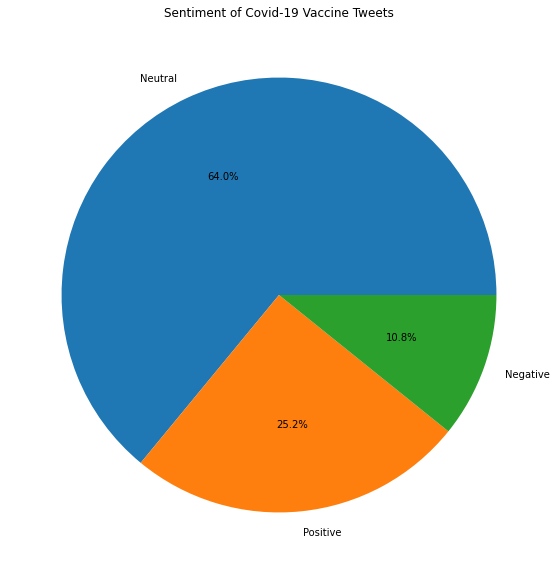

([<matplotlib.patches.Wedge at 0x7f77ce40e090>,
 [Text(-0.46935088152041804, 0.9948415703095678, 'Neutral'),
  Text(0.11195635209642742, -1.09428779360151, 'Positive'),
  Text(1.0374452551598383, -0.36566014623737453, 'Negative')],
 [Text(-0.2560095717384098, 0.5426408565324914, '64.0%'),
  Text(0.06106710114350586, -0.596884251055369, '25.2%'),
  Text(0.5658792300871845, -0.19945098885674972, '10.8%')])

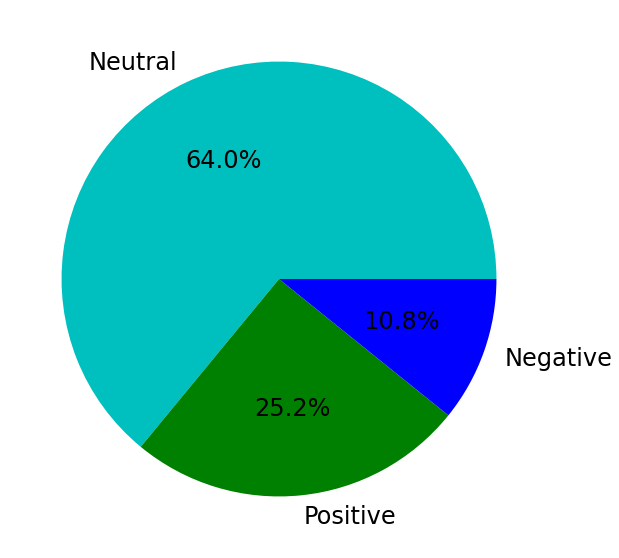

In [ ]:
neutral = counts.iat[0,0] 
positive = counts.iat[1,0] 
negative = counts.iat[2,0] 

Tasks = [neutral, positive, negative]
my_labels = 'Neutral','Positive','Negative'
plt.figure(figsize=(10,10))
plt.pie(Tasks,labels=my_labels,autopct='%1.1f%%')
plt.title('Sentiment of Covid-19 Vaccine Tweets')
#plt.axis('Percentages')
plt.show()
colors=('c', 'g', 'b')
plt.figure(figsize=(10,10))
plt.pie(Tasks, colors=colors ,labels=my_labels, 
       autopct='%1.1f%%', textprops={'fontsize': 24})

In [ ]:
tweets2.filter(tweets2.condition=="positive").show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------+---------------+---------+
|text                                                                                                                                            |text_non_ascii                                                                                                                                 |removed                                                                                                                        |sentiment_score|condition|
+-------------------------------------------------------------------------------------------------------------